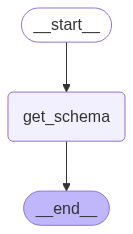

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain.chat_models import init_chat_model
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from pydantic import BaseModel


from dotenv import load_dotenv


load_dotenv(override=True)


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
)
model = init_chat_model("deepseek-chat", model_provider="deepseek")
tools = [multiply]
model_with_tools = model.bind_tools(tools)


class State(BaseModel):
    messages: list[str]
    db_schema: str


def assistant(state: MessagesState):
    return {"messages": [model_with_tools.invoke([sys_msg] + state["messages"])]}


def get_schema(state: State):
    state.db_schema = "gets database schema"
    return state


workdflow = StateGraph(MessagesState)

workdflow.add_node(get_schema)

workdflow.add_edge(START, "get_schema")
workdflow.add_edge("get_schema", END)

graph = workdflow.compile(checkpointer=MemorySaver())
display(Image(graph.get_graph().draw_mermaid_png()))
# print(graph.get_graph().draw_mermaid())
# print("--------------------------")
# print(graph.get_graph().draw_ascii())


config = {"configurable": {"thread_id": "1"}}

# Local LLM


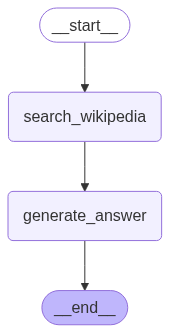

In [37]:
import os
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain.chat_models import init_chat_model
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from pydantic import BaseModel
import operator
from typing import Annotated, Any, TypedDict, Optional, cast
from langchain_core.documents import Document
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv

load_dotenv(override=True)


class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]


llm = init_chat_model(
    "qwen/qwen3-8b",
    temperature=0,
    model_provider="openai",
    base_url=os.getenv("LM_STUDIO_ENDPOINT", "http://0.0.0.0:1234/v1"),
    api_key="not-needed",
)


def search_web(state):
    """Retrieve docs from web search"""

    tavily_search = TavilySearchResults(max_results=1)
    search_docs = tavily_search.invoke(state["question"])

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def search_wikipedia(state):
    """Retrieve docs from wikipedia"""

    search_docs = WikipediaLoader(query=state["question"], load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def generate_answer(state):
    """Node to answer a question"""

    context = state["context"]
    question = state["question"]

    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, context=context)

    answer = llm.invoke(
        [SystemMessage(content=answer_instructions)]
        + [HumanMessage(content="Answer the question.")]
    )

    return {"answer": answer}


builder = StateGraph(State)

# builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_wikipedia")
# builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
# builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))


# model.invoke("hi, who are you?")


In [38]:
result = graph.invoke(
    cast(
        State,
        {
            "question": "Which was the latest released Barbie movie?",
        },
    )
)

result["answer"].content

'The latest released Barbie movie is *Barbie*, which was released in 2023.'

# Map


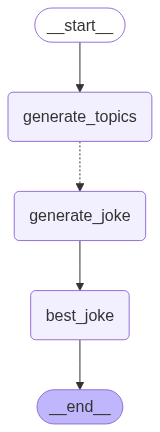

In [42]:
import os
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Send
from langchain.chat_models import init_chat_model
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from pydantic import BaseModel
import operator
from typing import Annotated, Any, TypedDict, Optional, cast
from langchain_core.documents import Document
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv

load_dotenv(override=True)


class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]


subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}"""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first one\n"""

llm = init_chat_model(
    "qwen/qwen3-8b",
    temperature=1,
    model_provider="openai",
    base_url=os.getenv("LM_STUDIO_ENDPOINT", "http://0.0.0.0:1234/v1"),
    api_key="not-needed",
)


class Subjects(BaseModel):
    subjects: list[str]


class BestJoke(BaseModel):
    id: int


class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = cast(Subjects, llm.with_structured_output(Subjects).invoke(prompt))
    return {"subjects": response.subjects}


def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


class JokeState(TypedDict):
    subject: str


class Joke(BaseModel):
    joke: str


def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = cast(Joke, llm.with_structured_output(Joke).invoke(prompt))
    return {"jokes": [response.joke]}


def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = cast(BestJoke, llm.with_structured_output(BestJoke).invoke(prompt))
    return {"best_selected_joke": state["jokes"][response.id]}


builder = StateGraph(OverallState)

builder.add_node("generate_topics", generate_topics)
builder.add_node("generate_joke", generate_joke)
builder.add_node("best_joke", best_joke)

builder.add_edge(START, "generate_topics")
builder.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
builder.add_edge("generate_joke", "best_joke")
builder.add_edge("best_joke", END)
graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))


# model.invoke("hi, who are you?")


In [45]:
for s in graph.stream(cast(OverallState, {"topic": "animals"})):
    print(s)

{'generate_topics': {'subjects': ['dogs', 'elephants', 'butterflies', 'sharks', 'penguins']}}
{'generate_joke': {'jokes': ["Why don't dogs ever get cold? Because they always have their tails in the fire!"]}}
{'generate_joke': {'jokes': ["Why don't elephants use computers? They have too many bytes!"]}}
{'generate_joke': {'jokes': ["Why don't penguins ever get cold? Because they've got a lot of friends to keep them warm!"]}}
{'generate_joke': {'jokes': ["Why don't butterflies ever get cold? Because they always carry their own 'wing' of heat!"]}}
{'generate_joke': {'jokes': ["Why don't sharks ever win at hide and seek? Because they always get caught in the first five minutes!"]}}
{'best_joke': {'best_selected_joke': "Why don't butterflies ever get cold? Because they always carry their own 'wing' of heat!"}}
